<a href="https://colab.research.google.com/github/mkorlyakova/MSTU-courses/blob/main/ML%20magister/7/ML_lec_6_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Регуляризация

Метод регуляризации заключается в "штрафовании" модели за слишком большие веса путем добавления нового члена к среднеквадратичной ошибке:

$$Q(w, X) + \lambda ||w||^{2} \rightarrow \underset{w}{\text{min}}.$$

добавленный член $\lambda ||w||^{2}$ - _квадратичный регуляризатор_, который представляет собой $L_{2}$-норму вектора весов, то есть сумму квадратов весов $\sum^{d}_{j=1}w_{j}^{2}$, коэффицент $\lambda$ при нем - коэффициент регуляризации. Чем больше его значение, тем меньшая сложность модели будет получаться в процессе такого обучения. Если увеличивать его, в какой-то момент оптимальным для модели окажется зануление всех весов. В то же время при слишком низких его значениях появляется вероятность чрезмерного усложнения модели и переобучения. Выбор оптимального значения этого коэфициента является отдельной задачей и заключается в многократном обучении модели с разными его значениями и сравнении их качества.

По сути, смысл регуляризации заключается, как и в обычном обучении, в минимизации функционала ошибки, только в данном случае добавляется условие непревышения нормой вектора весов некоторого значения $||w||^{2}\leq C$, то есть ограничение весов, что и будет залогом избежания переобучения.

Описанный выше метод с использованием $L_{2}$-нормы вектора весов в качестве регуляризатора называется _$L_{2}$-регуляризацией_. По аналогии существует также _$L_{1}$-регуляризация_, использующая в качестве регуляризатора $L_{1}$-норму вектора весов, то есть сумму модулей весов.

$$||w||_{1} = \sum^{d}_{j=1}|w_{j}|.$$

$L_{2}$-регуляризатор представляет собой непрерывную гладкую функцию, поэтому его добавление не усложняет использование градиентных методов оптимизации, так как в каждой его точке существует производная. $L_{1}$-регуляризатор уже не является гладкой функцией, так как в нем есть модуль, у которого не существует производной в нуле. То есть его использование усложняет градиентные методы оптимизации, но в свою очередь он обладает интересной особенностью, заключающейся в занулении некоторых весов при его применении. Иными словами, он производит отбор признаков, позволяя оставлять только самые важные, отбрасывая остальные.

$L_{1}$-регуляризация также называется Lasso, $L_{2}$-регуляризация иногда называется Ridge. По этим именам регуляризаторы можно найти в модуле `sklearn.linear_models`.

In [228]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet

from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

import numpy as np

In [230]:
data2, target2, coef = datasets.make_regression(n_samples=1000, n_features = 2, n_informative = 2, n_targets = 1, 
                                              noise = 0.5, coef = True, random_state = 2)
target3 = np.sum(data2 ** 2,1) + 1
target3 =target3.reshape(-1,1)
n = 3
data3 = PolynomialFeatures(degree=n).fit_transform(data2)


In [231]:
data2[:3,:]

array([[ 0.37879447, -0.61837549],
       [-0.65293115, -1.06706712],
       [-1.06581629, -0.34682333]])

In [232]:
data3[:3,:]

array([[ 1.        ,  0.37879447, -0.61837549,  0.14348525, -0.23423721,
         0.38238824,  0.05435142, -0.08872776,  0.14484655, -0.23645951],
       [ 1.        , -0.65293115, -1.06706712,  0.42631908,  0.69672136,
         1.13863225, -0.27835701, -0.45491107, -0.74344846, -1.21499704],
       [ 1.        , -1.06581629, -0.34682333,  1.13596436,  0.36964996,
         0.12028643, -1.21072932, -0.39397895, -0.12820323, -0.04171814]])

In [233]:
data3.shape

(1000, 10)

In [236]:
# реализуем функцию, определяющую среднеквадратичную ошибку
def mserror(X, w, y_pred):
    y = X.dot(w)
    return (sum((y - y_pred)**2)) / len(y)

In [237]:
# инициализируем начальный вектор весов
w = np.zeros((10,1))#np.random.randn(data3.shape[1]).reshape(-1,1) # Это частный случай
 
# список векторов весов после каждой итерации
w_list = [w.copy().T]
 
# список значений ошибок после каждой итерации
errors = []
 
# шаг градиентного спуска
eta = 0.15/100
 
# максимальное число итераций
max_iter = 1e2
 
# критерий сходимости (разница весов, при которой алгоритм останавливается)
min_weight_dist = 1e-8
 
# зададим начальную разницу весов большим числом
weight_dist = np.inf
 
# счетчик итераций
iter_num = 0
lamb = 0.01 
q = 100/100
np.random.seed(1234)

Q = [mserror(data3, w, target3)[0]]  
# ход градиентного спуска
while weight_dist > min_weight_dist and iter_num < max_iter:
    
    # генерируем случайный индекс объекта выборки
    train_ind = np.random.randint(data3.shape[0])
    #производная потерь
    
    dQ = np.dot(data3[train_ind:train_ind+1,:].T, (np.dot(data3[train_ind:train_ind+1,:], w) - target3[train_ind,0]))
    dL1 = np.sign(w) # производная для штрафа сложности
    
    new_w = w - 2 * eta * (dQ + q*dL1) #/ target3.shape[0] - нужно ставить небольшое значение скорости обучения
     
    weight_dist = np.linalg.norm(new_w - w, ord=2)
    
    w_list.append(new_w.copy())
    errors.append(mserror(data3, new_w, target3)[0])
    Q.append(Q[-1]*(1-lamb)+lamb*(np.dot(data3[train_ind,:], w) - target3[train_ind])**2)
    iter_num += 1
    w = new_w
    
w_list = np.array(w_list)
 
print(f'В случае использования стохастического градиентного спуска функционал ошибки составляет {round(errors[-1], 4)}')

В случае использования стохастического градиентного спуска функционал ошибки составляет 2.8285


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [ ]:
w

array([[ 0.31264221],
       [ 0.01403876],
       [-0.00369241],
       [ 0.61256275],
       [ 0.00645102],
       [ 0.59179386],
       [ 0.01360269],
       [ 0.02011139],
       [-0.14174317],
       [ 0.0125688 ]])

## Деревья решений

Метод основан на известной структуре данных - деревьях, которые по сути представляют собой последовательные инструкции с условиями. Например, классификация кот/собака:
  - 1) бинокулярное зрение
  - 2) острые уши
  - 3) щелевидный зрачок

В листьях (терминальных узлах) деревьев стоят значения целевой функции (прогноз), а в узлах - условия перехода, определяющие, по какому из ребер идти. Если речь идет о бинарных деревьях (каждый узел производит ветвление на две части), обычно, если условие в узле истинно, то происходит переход по левому ребру, если ложно, то по правому. 



In [10]:
# визуализировать дерево можно с помощью библиотеки python-graphviz
# https://nbviewer.jupyter.org/github/xflr6/graphviz/blob/master/examples/graphviz-notebook.ipynb
!pip install graphviz
import graphviz
from graphviz import Digraph



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [11]:

import logging
logging.basicConfig(format='[%(levelname)s@%(name)s] %(message)s', level=logging.DEBUG)

In [12]:
dot = Digraph(node_attr={'shape': 'box'})

dot.node('A', label='глаза смотрят вперед?')
dot.node('B', label='уши острые?')
dot.node('C', label='собака')
dot.node('D', label='зрачки щелевые?')
dot.node('E', label='собака')
dot.node('F', label='кот')
dot.node('G', label='собака')

dot.edge('A', 'B', label='да')
dot.edge('A', 'C', label='нет')
dot.edge('B', 'D', label='да')
dot.edge('B', 'E', label='нет')
dot.edge('D', 'F', label='да')
dot.edge('D', 'G', label='нет')

print(dot.source)  

digraph {
	node [shape=box]
	A [label="глаза смотрят вперед?"]
	B [label="уши острые?"]
	C [label="собака"]
	D [label="зрачки щелевые?"]
	E [label="собака"]
	F [label="кот"]
	G [label="собака"]
	A -> B [label="да"]
	A -> C [label="нет"]
	B -> D [label="да"]
	B -> E [label="нет"]
	D -> F [label="да"]
	D -> G [label="нет"]
}


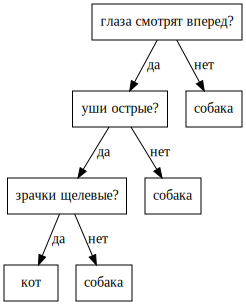

In [13]:
dot

In [14]:
logging.basicConfig(format='[%(levelname)s@%(name)s] %(message)s', level=logging.FATAL)

Чаще всего в вершинах прописываются максимально простые условия. Обычно это сравнение значения одного из признаков $x^{j}$ с некоторым заданным порогом $t$:

$$[x^{j} \leq t].$$

Если решается задача классификации, конечным прогнозом является класс или распределение вероятностей классов. В случае регрессии прогноз в листе является вещественным числом.

Большим плюсом деревьев является тот факт, что они легко интерпретируемы. 

## Построение деревьев решений

Деревья строятся последовательно от корня к листьям (так называемый "жадный" способ):
  - Выбирается корень и критерий, по которому выборка разбивается на две. 
  - То же самое делается для каждого из потомков этого корня и так далее до достаточного уровня ветвления. 
  
  Критичные задачи:
    - Выбор способа **разбиения каждого из узлов**, то есть в выборе значения порога, с которым будет сравниваться значение одного из признаков в каждом узле.
    - Назначить критерий останова
    - Определить способ привязывания оценки терминального узла

### Разбиение в узле
**Разбиение** выбирается с точки зрения заранее заданного функционала качества $Q(X, j, t)$. Находятся наилучшие значения $j$ и $t$ для создания _предиката_ $[x^{j}<t]$. **Параметры $j$ и $t$ можно выбирать перебором:** признаков конечное число, а из всех возможных значений порога $t$ можно рассматривать только те, при которых получаются различные разбиения на две подвыборки, таким образом, различных значений параметра $t$ будет столько же, сколько различных значений признака $x^{j}$ в обучающей выборке.

В каждой вершине производится проверка, не выполнилось ли некоторое условие останова (критерии останова рассмотрим далее), и если оно выполнилось, разбиение прекращается, и вершина объвляется листом, и он будет содержать прогноз.


Лист: 

    0(y1)  0(y2) 0 0 1
1) y=0,     4 объекта

2) y=1, 1 Объект

y=0

1) y=0,     4 объекта

2) y=1, 1 Объект

4/5 1/5

(0,2 + 0,3 + 0,5)/3

За функционал качества при работе с деревом решений принимается функционал вида

$$Q(X_{m}, j, t) = H(X_{m}) - \frac{|X_{l}|}{|X_{m}|}H(X_{l}) - \frac{|X_{r}|}{|X_{m}|}H(X_{r}),$$

где $X_{m}$ - множество объектов, попавших в вершину на данном шаге, $X_{l}$ и $X_{r}$ - множества, попадающие в левое и правое поддерево, соответственно, после разбиения. $H(X)$ - _критерий информативности_. Он оценивает качество распределения объектов в подмножестве и тем меньше, чем меньше разнообразие ответов в $X$, соответственно, задача обучения состоит в его минимизации и, соответственно, максимизации $Q(X_{m}, j, t)$ на данном шаге. Последний, по сути, характеризует прирост качества на данном шаге.

В формуле значения критериев информативности нормируются - домножаются на долю объектов, ушедших в соответствующее подмножество. Например, если у нас множество в узле разбилось на два подмножества размером в 9990 объектов и 10 объектов, но при этом в первом подмножестве все объекты будут принадлежать к одному классу (то есть иметь минимальное значение разброса), а во втором - к разным, то в целом разбиение будет считаться хорошим, так как подавляющее большинство отсортировано правильно.

### Критерий информативности

В случае **регрессии** разброс будет характеризоваться дисперсией, поэтому критерий информативности будет записан в виде

$$H(X) = \frac{1}{X}\sum_{i\in X}(y_{i} - \bar{y}(X))^{2},$$

где $\bar{y}(X)$ - среднее значение ответа в выборке $X$:

$$\bar{y}(X) = \frac{1}{|X|}\sum_{i\in X}y_{i}.$$

В задаче **классификации** есть несколько способов определить критерий информативности.

**1)** Обозначим через $p_{k}$ долю объектов класса $k$ в выборке $X$:

$$p_{k} = \frac{1}{|X|}\sum_{i\in X}[y_{i} = k].$$

$p_{k}$ будет характеризовать вероятность выдачи класса $k$.

**2)** _Критерий Джини_ или _индекс Джини_ выглядит следующим образом:

$$H(X) = \sum^{K}_{k=1}p_{k}(1-p_{k}),$$

где $K$ - количество классов в наборе данных $X$.

Его минимум достигается когда все объекты в подмножестве относятся к одному классу, а максимум - при равном содержании объектов всех класов. Критерий информативности Джини можно интерпретировать как вероятность ошибки случайного классификатора.

**3)** Еще один критерий информативности - _энтропийный критерий_. Он также называется _энтропией Шеннона_ и записывается как

$$H(X) = - \sum^{K}_{k=1}p_{k}\text{log}_{2}p_{k}.$$

Минимум энтропии также достигается когда все объекты относятся к одному класссу, а максимум - при равномерном распределении. Прирост информации есть утрата неопределенности (=уменьшение энтропии). Стоит отметить, что в формуле полагается, что $0\text{log}_{2}0=0.$ 


In [17]:
import numpy as np
import matplotlib.pyplot as plt


In [18]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity, classes

In [19]:
X = np.array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
              [1, 1, 2, 5, 3, 0, 5, 10, 1, 2],
              [500, 700, 750, 600, 1450, 800, 1500, 2000, 450, 1000],
              [1, 1, 2, 1, 2, 1, 3, 3, 1, 2]], dtype = np.float64)
y = np.array([0, 0, 1, 0, 1, 0, 1, 0, 1, 1], dtype = np.float64)

In [20]:
x = X[2,:]
print(x)
print(y)
N1000 = 1560
print(x >= N1000)
print(y[x >= N1000])
right_1 = (y[x >= N1000] == 0)
right_2 = (y[x >= N1000] == 1)
print('Нулей:', right_1.sum(), 'единиц:', right_2.sum())

[ 500.  700.  750.  600. 1450.  800. 1500. 2000.  450. 1000.]
[0. 0. 1. 0. 1. 0. 1. 0. 1. 1.]
[False False False False False False False  True False False]
[0.]
Нулей: 1 единиц: 0


Как работает коэффициент Джини

In [21]:
print(y[x >= N1000])
i, c = gini(y[x >= N1000])
print(i, c)

print(y[x < N1000])
i, c = gini(y[x < N1000])
print(i, c)

[0.]
0.0 {0.0: 1}
[0. 0. 1. 0. 1. 0. 1. 1. 1.]
0.49382716049382713 {0.0: 4, 1.0: 5}


In [22]:

def quality_0(left_labels, right_labels):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    gini_left, _ = gini(left_labels)
    gini_right, _ = gini(right_labels)
    
    return p * gini_left + (1 - p) * gini_right, p * gini_left , (1 - p) * gini_right

Порог: 500.0, gini = 0.4444444444444444 (0.0,0.4444444444444444)
Порог: 700.0, gini = 0.47619047619047616 (0.13333333333333333,0.34285714285714286)
Порог: 750.0, gini = 0.4166666666666667 (0.15000000000000002,0.26666666666666666)
Порог: 600.0, gini = 0.5 (0.1,0.4)
Порог: 1450.0, gini = 0.4761904761904763 (0.3428571428571429,0.13333333333333336)
Порог: 800.0, gini = 0.48 (0.24,0.24)
Порог: 1500.0, gini = 0.5 (0.4,0.09999999999999998)
Порог: 2000.0, gini = 0.4444444444444444 (0.4444444444444444,0.0)
Порог: 450.0, gini = 0.5 (0.0,0.5)
Порог: 1000.0, gini = 0.4166666666666667 (0.26666666666666666,0.15000000000000002)


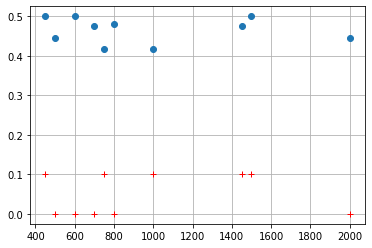

In [23]:
Gini_tr = []
for t in x:
    g, lg,rg = quality_0(y[x < t], y[x >= t])
    Gini_tr.append([t,g])
    print('Порог: {}, gini = {} ({},{})'.format(t,g,lg,rg ))

Gini_tr = np.array(Gini_tr)


plt.plot(Gini_tr[:,0],Gini_tr[:,1], 'o')
plt.plot(x,y/10,'+r', )
plt.grid(True)
plt.show()    


### Значение терминального узла. 
В задаче классификации это будет класс, к которому относится большая часть объектов из выборки в листе $X_{m}$

$$a_{m} = \text{argmax}_{y \in Y} \sum_{i \in X_{m}}[y_{i}=y]$$

или доля объектов определенного класса $k$, если требуется предсказать вероятности классов

$$a_{mk} = \frac{1}{|X_{m}|} \sum_{i \in X_{m}}[y_{i}=k].$$

В случае регрессии можно в качестве ответа давать средний по выборке в листе

$$a_{m} = \frac{1}{|X_{m}|} \sum_{i \in X_{m}}y_{i}.$$

### Критерии останова

_Критерии останова_ - это критерии, которые показывают, нужно ли остановить процесс построения дерева. Правильный выбор критериев останова роста дерева может существенно повлиять на его качество. Существует большое количество возможных ограничений:

- Ограничение максимальной глубины дерева. Этот критерий считается достаточно грубым, но хорошо зарекомендовавшим себя в построении композиций деревьев - когда несколько деревьев объединяются в один алгоритм.


- Ограничение максимального количества листьев.


- Ограничение минимального количества $n$ объектов в листе. При этом оно должно быть достаточным, чтобы построить надежный прогноз.


- Останов в случае, когда все объекты в листе относятся к одному классу.


- Требование улучшения функционала качества при разбиении на какую-то минимальную величину.

Подбор оптимальных критериев - сложная задача, которая обычно решается методом кросс-валидации.

## CART

CART (Classification and regression trees) - первый из алгоритмов, состоящий в обычном последовательном построении дерева решений и придуманный в 1983 году. На первой итерации строятся все возможные разбиения исходного пространства на два и выбирается такое, при котором максимально выделен один из классов в одно подпространство. На следующих итерациях выбирается худший лист (с наибольшим разнообразием классов), и на нем проводится та же операция. Так продложается до достижения одного из критериев останова. 

Полученное дерево будет подогнано под обучающую выборку (переобучено), так что затем требуется его кросс-валидация или обрезка методом cost-complexity pruning. 

В качестве функции оценки качества разбиения используется критерий Джини, который также может быть записан как

$$H(X) = 1 - \sum^{K}_{k=1}p_{k}^{2}.$$

в sklearn реализована улучшенная версия именно алгоритма CART.

## Реализация дерева решений

Реализуем алгоритм алгоритм работы дерева решений своими руками.

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

In [25]:
# сгенерируем данные
classification_data, classification_labels = datasets.make_classification(n_samples = 200,n_features = 2, n_informative = 2, 
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=15)

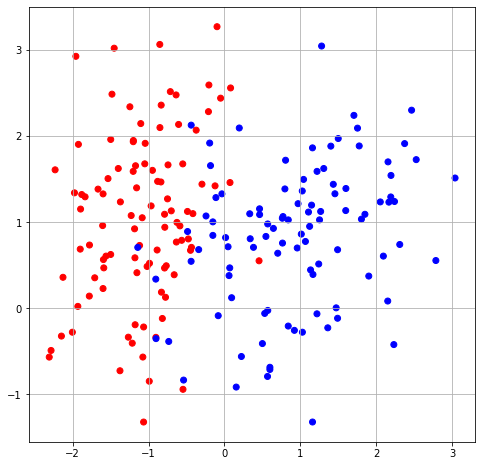

In [26]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)
plt.grid()
plt.show()

In [27]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [28]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data # значения признаков
        self.labels = labels  # y_true
        self.prediction = self.predict()  # y_pred
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его   
        prediction = max(classes, key=classes.get)
        return prediction

Обозначим через $p_{k}$ долю объектов класса $k$ в выборке $X$: $$p_{k} = \frac{1}{|X|}\sum_{i\in X}[y_{i} = k].$$
$p_{k}$ будет характеризовать вероятность выдачи класса $k$.

In [29]:
# p = classes[label] / len(labels)

Критерий Джини, который также может быть записан как

$$H(X) = 1 - \sum^{K}_{k=1}p_{k}^{2}.$$

In [30]:
# impurity -= p ** 2

In [31]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1     # "impurity" - "нечистота", степень неопределенности
    for label in classes:
        p = classes[label] / len(labels) # долю объектов класса в листе
        impurity -= p ** 2 # Критерий Джини
        
    return impurity

Функционал качества

$$Q(X_{m}, j, t) = H(X_{m}) - \frac{|X_{l}|}{|X_{m}|}H(X_{l}) - \frac{|X_{r}|}{|X_{m}|}H(X_{r}),$$

In [32]:
# current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

$$\frac{|X_{l}|}{|X_{m}|}$$

In [33]:
# float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])

In [34]:
# Расчет качества

def quality(left_labels, right_labels, current_gini):

    # доля выборки, ушедшей в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0]) # для правого (1-p)
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels) # Функционал качества

In [35]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [36]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 2

    current_gini = gini(labels) 

    best_quality = 0
    best_t = None # лучший порог разбиения
    best_index = None # лучший индекс разбиения
    
    n_features = data.shape[1] # кол-во признаков
    
    for index in range(n_features): # проход по всем признакам
        t_values = [row[index] for row in data] # берем столбец/признак с соотв. индексом
        
        for t in t_values: # проход по признаку
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t) # делаем разбиение
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue # начинаем следующий проход цикла, минуя оставшееся тело цикла
            
            # расчет качества текущего разбиения
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [37]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):

    quality, t, index = find_best_split(data, labels) # ищем лучшее разбиение
#     print(quality, t, index)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    # неопределенность после разбиения осталась такой же как до
    if quality == 0: # критерий останова
#         print('leaf')
        return Leaf(data, labels) # считаем прогноз для листьев

    # если качество улучшилось, то делим дерево по лучшему разбиению
    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [38]:
# Проход объекта по дереву для его классификации

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf): # проверка текущий узел это лист?
        answer = node.prediction # считаем прогноз для листа
        return answer

    if obj[node.index] <= node.t: # если значение признака меньше порога t
        return classify_object(obj, node.true_branch) # рекурсия: отправляем объект в true-ветку
    else:
        return classify_object(obj, node.false_branch) # рекурсия: отправляем объект в false-ветку

In [39]:
# Предсказание деревом для всего датасета

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree) # определяем ветки для объектов
        classes.append(prediction)
    return classes

In [40]:
# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 2)

In [41]:
# Построим дерево по обучающей выборке
my_tree = build_tree(train_data, train_labels)
print(my_tree)
display(my_tree.index, my_tree.t, my_tree.true_branch , my_tree.false_branch)

0

-0.09730308973766422

In [42]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index))
    print(spacing + 'Порог', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на отрицательном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")
    
print_tree(my_tree)

Индекс 0
Порог -0.09730308973766422
--> True:
  Индекс 0
  Порог -0.5459200502019997
  --> True:
    Индекс 1
    Порог -0.35122823125929337
    --> True:
      Индекс 1
      Порог -0.48884788378983535
      --> True:
        Прогноз: 0
      --> False:
        Прогноз: 1
    --> False:
      Индекс 1
      Порог 0.7080176349931291
      --> True:
        Индекс 1
        Порог 0.6258995630916202
        --> True:
          Прогноз: 0
        --> False:
          Прогноз: 0
      --> False:
        Прогноз: 0
  --> False:
    Индекс 1
    Порог 1.0730692204484045
    --> True:
      Индекс 0
      Порог -0.43442042576709183
      --> True:
        Индекс 0
        Порог -0.4857086973471523
        --> True:
          Прогноз: 1
        --> False:
          Прогноз: 0
      --> False:
        Прогноз: 1
    --> False:
      Индекс 0
      Порог -0.43772671880149305
      --> True:
        Прогноз: 0
      --> False:
        Прогноз: 0
--> False:
  Индекс 0
  Порог 0.08154335867939544
 

In [43]:
# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)
train_answers[:5]

[1, 1, 0, 0, 1]

In [44]:
# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)

Accuracy = расчет *доли правильных ответов*:

$$accuracy(a,x) = \frac{1}{l} \sum^{l}_{i=1}[a(x_{i})=y_{i}].$$

In [45]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [46]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
train_accuracy

97.85714285714285

In [47]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, answers)
test_accuracy

88.33333333333333

Text(0.5, 1.0, 'Test accuracy=88.33')

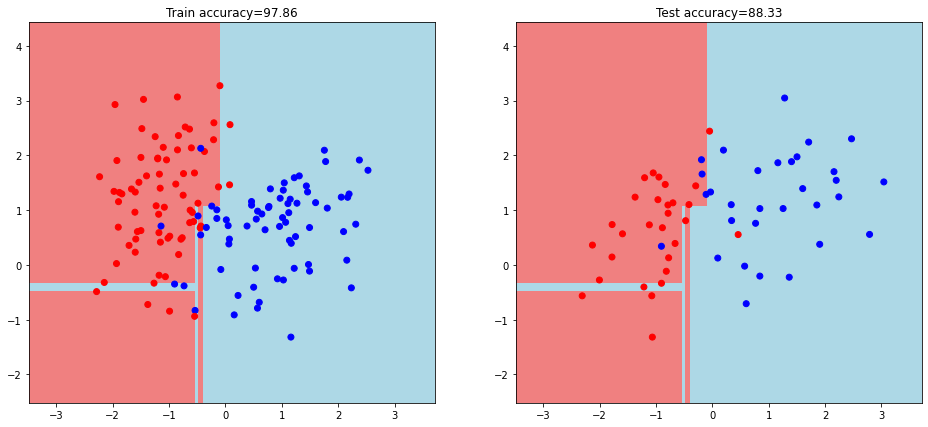

In [48]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step)) # список массивов координатных сеток

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape) # определяем цвета квадратов в сетке
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')

Как видно, дерево строит кусочно-постоянную разделяющую гиперплоскость, то есть состоящую из прямых, параллельных осям. Чем глубже дерево, тем сложнее гиперплоскость. Также происходит и в случае регрессии - график зависимости целевого значения восстанавливается кусочно-постоянной функцией.

Деревья обладают и отрицательными качествами - в частности, они очень легко переобучаются. Легко построить дерево, в котором каждый лист будет соответствовать одному объекту обучающей выборки. Оно будет идеально подогнано под обучающую выборку, давать стопроцентный ответ на ней, но при этом не будет восстанавливать оригинальных закономерностей, и качество ответов на новых данных будет неудовлетворительным.

### Обрезка деревьев

После построения дерева может проводиться его _стрижка_ (pruning) - удаление некоторых вершин согласно некоторому подходу с целью понижения сложности модели и повышения обобщающей способности.

В случае применения метода стрижки (обрезки, прунинга) деревьев использовать критерии останова необязательно, и можно строить переобученные деревья, затем снижая их сложность, удаляя листья по некоторому критерию (например, пока улучшается качество на отложенной выборке). Считается, что стрижка работает лучше, чем критерии останова.

Одним из методов стрижки является _cost-complexity pruning_. Допустим, мы построили дерево, обозначенное как $T_{0}$. В каждом из листьев находятся объекты одного класса, и значение функционала ошибки $R(T)$ при этом будет минимально на $T_{0}$. Для борьбы с переобучением к нему добавляют "штраф" за размер дерева (аналогично регуляризации, рассмотренной нами в предыдущих уроках) и получают новый функционал $R_{\alpha}(T)$:

$$R_{\alpha}(T) = R(T) + \alpha|T|,$$

где $|T|$ - число листьев в дереве, $\alpha$ - некоторый параметр регуляризации. Таким образом если при построении дерева на каком-то этапе построения алгоритма ошибка будет неизменна, а глубина дерева увеличиваться, итоговый функционал, состоящий из их суммы, будет расти.

Однако стрижка деревьев обладает существенными минусами. В частности, она является очень трудоемкой процедурой. Например, она может требовать вычисления функционала качества на валидационной выборке на каждом шаге. К тому же, на данный момент одиночные деревья на практике почти не используются, а используются композиции деревьев, и в этом случае стрижка как метод борьбы с переобучением становится еще более сложным подходом. Обычно в такой ситуации достаточно использовать простые критерии останова.

## Работа деревьев в случае пропущенных значений

Иногда в реальных задачах бывает так, что не для всех объектов известно значение того или иного признака. Одним из преимуществ деревьев решений является возможность обрабатывать такие случаи.

Допустим, требуется вычислить функционал качества для разбиения $[x_{j}<t]$, но в выборке $X_{m}$ для некоторого подмножества объектов $V_{j}$ неизвестно значение $j$-го признака. В этом случае функционал качества рассчитывается без учета этих объектов (обозначим выборку без их учета как $X_{m}\text{\ }V_{j}$), с поправкой на потерю информации:

$$Q_{X_{m}, j, t} = \frac{|X_{m}\text{\ } V_{j}|}{|X_{m}|}Q(X_{m}\text{\ }V_{j}, j,t).$$

Если такое разбиение окажется лучшим, объекты из $V_{j}$ помещаются в оба образованных поддерева.

На этапе применения дерева выполняется похожая операция. Если объект попал в вершину, в которой нельзя вычислить критерий разбиения из-за отсутствия значения необходимого признака, прогнозы для него вычисляются в обоих поддеревьях, а затем усредняются с весами, пропорциональными числу объектов в них.

$$\frac{|X_{l}|}{|X_{m}|}a_{l}(x) + \frac{|X_{r}|}{|X_{m}|}a_{r}(x),$$

где $a$ - прогноз вероятности отнесения объекта $x$ к одному из классов.

Кроме этого подхода существует метод построения _суррогатных предикатов_ в каждой вершине. Проще говоря, это запасной предикат, который использует другой признак, но при этом дает максимально близкое к исходному разбиение.

## Работа деревьев с категориальными признаками

Кроме вещественных и бинарных признаков в задаче могут иметь место категориальные признаки (делящиеся на конечное число категорий, например, цвета автомобилей). Самый простой способ учета категориальных признаков в алгоритме деревьев состоит в разбитии вершины на столько поддеревьев, сколько имеется возможных значений признака. В этом случае дерево называется _n-арным_. Условие разбиения будет простым (отнесение признака к той или иной категории), однако здесь появляется риск получения конечного дерева с очень большим числом листьев. В случае такого дерева критерий ошибки $Q$ будет состоять из $n$ слагаемых (или из $(n+1)$) в случае максимизируемого критерия, который мы использовали.

Есть и другой подход, заключающийся в формировании бинарных деревьев путем разделения множества значений признака $C = \{c_{1}, ...,c_{n}\}$ на два непересекающихся подмножества $C_{1}$ и $C_{2}$. После такого разделения условием разбиения в узле будет проверка принадлежности признака одному из подмножеств $[x \in C_{1}]$.

Задача остается в выборе оптимального варианта разбиения исходного множества на два подмножества, так как обычный перебор всех вариантов может быть крайне затруднительным из-за большого количества вариантов разбиения. В случаях с бинарной классификацией и регрессией используют следующий метод: все возможные значения категориального признака сортируются по определенному принципу, затем заменяются на натуральные числа.

В случае бинарной классификации признаки упорядочиваются на основе того, какая доля объектов с такими признаками относится к классу +1. Если обозначить множество объектов в узле $m$, у которых $j$-й признак имеет значение $с$, через $X_{m}(c)$, а через $N_{m}(c)$ количество таких объектов, получим:

$$\frac{1}{N_{m}(c_{1})} \sum_{x \in X_{m}(c_{1})}[y_{i}=+1]\leq...\leq \frac{1}{N_{m}(c_{n})} \sum_{x \in X_{m}(c_{n})}[y_{i}=+1],$$

и после замены категории $c_{i}$ на натуральное число ищется разбиение как для вещественного признака.

В случае задачи регрессии сортировка происходит схожим образом, но вместо доли объектов положительного класса среди объектов с таким значением признака вычисляется средний ответ по объектам с соответствующим значением категориального признака:

$$\frac{1}{N_{m}(c_{1})} \sum_{x \in X_{m}(c_{1})}y_{i}\leq...\leq \frac{1}{N_{m}(c_{n})} \sum_{x \in X_{m}(c_{n})}y_{i}.$$

Решающее дерево: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html 

In [49]:
from sklearn.tree import DecisionTreeClassifier

In [50]:
clf = DecisionTreeClassifier(random_state=0, max_depth=6)
clf.fit(train_data, train_labels)


DecisionTreeClassifier(max_depth=6, random_state=0)

In [51]:
# Точность на обучающей выборке
train_accuracy_s = accuracy_metric(train_labels,clf.predict(train_data))
train_accuracy_s,train_accuracy

(100.0, 97.85714285714285)

In [52]:
# Точность на тестовой выборке
test_accuracy_s = accuracy_metric(test_labels,clf.predict(test_data))
test_accuracy_s,test_accuracy

(80.0, 88.33333333333333)

Text(0.5, 1.0, 'Test accuracy=80.00')

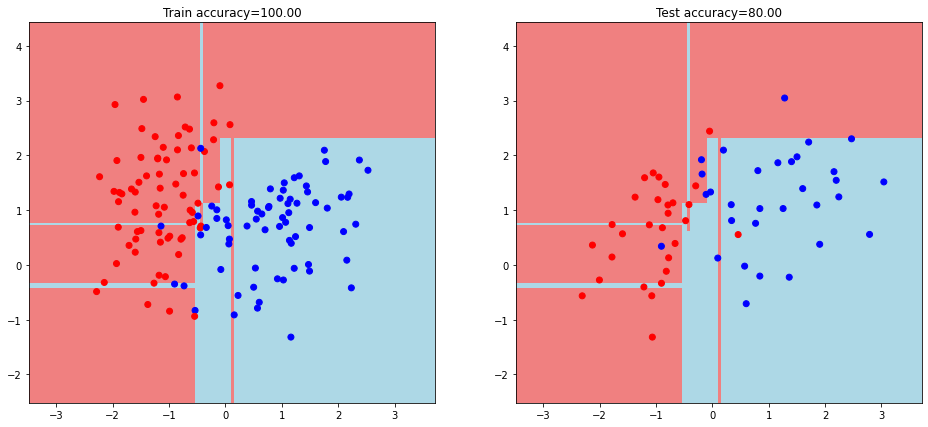

In [53]:
plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(clf.predict(np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape) # определяем цвета квадратов в сетке
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy_s:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy_s:.2f}')

In [54]:
logging.basicConfig(format='[%(levelname)s@%(name)s] %(message)s', level=logging.disable)

[Text(0.6363636363636364, 0.9285714285714286, 'X[0] <= -0.089\ngini = 0.5\nsamples = 140\nvalue = [71, 69]'),
 Text(0.36363636363636365, 0.7857142857142857, 'X[0] <= -0.542\ngini = 0.237\nsamples = 80\nvalue = [69, 11]'),
 Text(0.18181818181818182, 0.6428571428571429, 'X[1] <= -0.343\ngini = 0.089\nsamples = 64\nvalue = [61, 3]'),
 Text(0.09090909090909091, 0.5, 'X[1] <= -0.437\ngini = 0.444\nsamples = 6\nvalue = [4, 2]'),
 Text(0.045454545454545456, 0.35714285714285715, 'gini = 0.0\nsamples = 4\nvalue = [4, 0]'),
 Text(0.13636363636363635, 0.35714285714285715, 'gini = 0.0\nsamples = 2\nvalue = [0, 2]'),
 Text(0.2727272727272727, 0.5, 'X[1] <= 0.739\ngini = 0.034\nsamples = 58\nvalue = [57, 1]'),
 Text(0.22727272727272727, 0.35714285714285715, 'X[1] <= 0.698\ngini = 0.1\nsamples = 19\nvalue = [18, 1]'),
 Text(0.18181818181818182, 0.21428571428571427, 'gini = 0.0\nsamples = 18\nvalue = [18, 0]'),
 Text(0.2727272727272727, 0.21428571428571427, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),


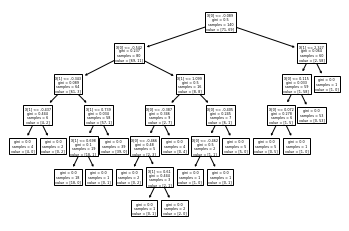

In [55]:
from sklearn import tree

tree.plot_tree(clf) 

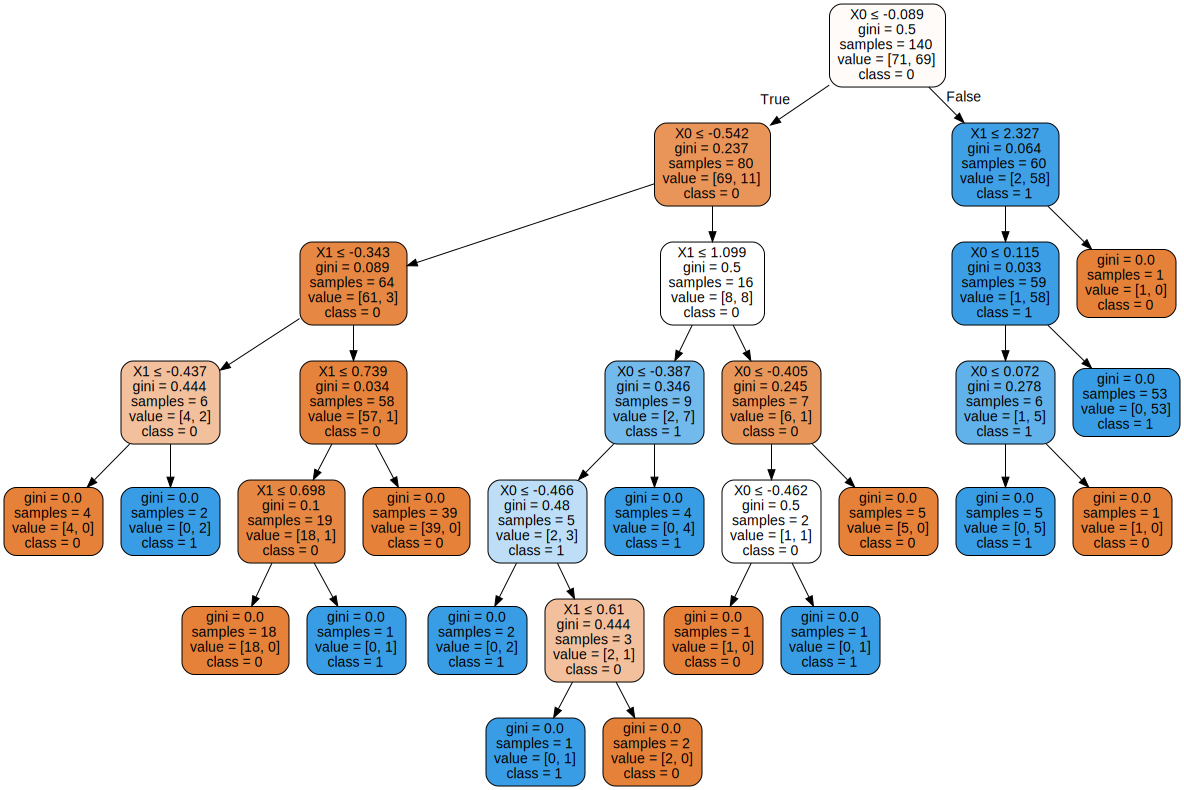

In [56]:
dot_data = tree.export_graphviz(clf, out_file=None,feature_names=['X0','X1'],class_names=['0','1'], filled=True, rounded=True,special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

### **Гиперпараметры:**

  - Высота (глубина ) дерева
  - число примеров в листе
  - способ разбиения 
  - способы выбора признаков для разбиения
  

In [60]:
def class_DT(train_data, train_labels,test_data,test_labels, max_depth=3, min_samples_leaf=2, min_samples_split = 2 , max_features = 0.5 ):
  clf = DecisionTreeClassifier(random_state=0, max_depth=max_depth, min_samples_leaf=min_samples_leaf, min_samples_split = min_samples_split , max_features = max_features )
  clf.fit(train_data, train_labels)
  # Точность на обучающей выборке
  train_accuracy_s = accuracy_metric(train_labels,clf.predict(train_data))
  # Точность на тестовой выборке
  test_accuracy_s = accuracy_metric(test_labels,clf.predict(test_data))
  return train_accuracy_s,test_accuracy_s


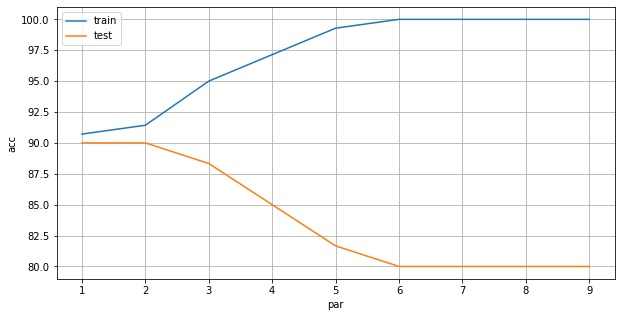

In [70]:
acc = []
par = []
for i in range(1,10):
  acc_train, acc_test = class_DT(train_data, train_labels,test_data,test_labels, max_depth=i, min_samples_leaf=1, min_samples_split = 2 , max_features = 1. )
  par += [i]
  acc += [[acc_train, acc_test]]
acc = np.array(acc)
plt.figure(figsize = (10,5))
plt.plot(par,acc[:,0], label = 'train')
plt.plot(par,acc[:,1], label = 'test') 
plt.legend()
plt.xlabel('par')
plt.ylabel('acc')
plt.grid()
plt.show() 

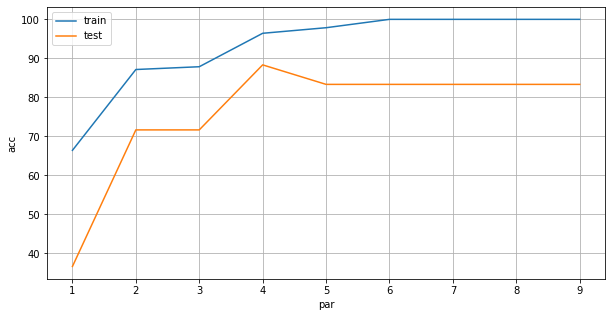

In [71]:
acc = []
par = []
for i in range(1,10):
  acc_train, acc_test = class_DT(train_data, train_labels,test_data,test_labels, max_depth=i, min_samples_leaf=1, min_samples_split = 2 , max_features = 0.5 )
  par += [i]
  acc += [[acc_train, acc_test]]
acc = np.array(acc)
plt.figure(figsize = (10,5))
plt.plot(par,acc[:,0], label = 'train')
plt.plot(par,acc[:,1], label = 'test') 
plt.legend()
plt.xlabel('par')
plt.ylabel('acc')
plt.grid()
plt.show() 

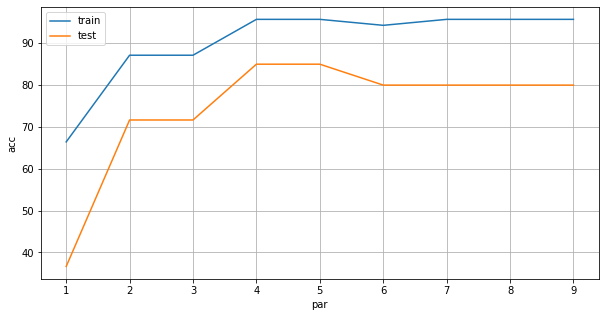

In [72]:
acc = []
par = []
for i in range(1,10):
  acc_train, acc_test = class_DT(train_data, train_labels,test_data,test_labels, max_depth=i, min_samples_leaf=3, min_samples_split = 2 , max_features = 0.5 )
  par += [i]
  acc += [[acc_train, acc_test]]
acc = np.array(acc)
plt.figure(figsize = (10,5))
plt.plot(par,acc[:,0], label = 'train')
plt.plot(par,acc[:,1], label = 'test') 
plt.legend()
plt.xlabel('par')
plt.ylabel('acc')
plt.grid()
plt.show() 

## Дополнительные материалы

1. [Энтропия](https://habr.com/ru/post/305794/)
2. [Энтропия - теоретическое обоснование](https://ru.wikipedia.org/wiki/%D0%98%D0%BD%D1%84%D0%BE%D1%80%D0%BC%D0%B0%D1%86%D0%B8%D0%BE%D0%BD%D0%BD%D0%B0%D1%8F_%D1%8D%D0%BD%D1%82%D1%80%D0%BE%D0%BF%D0%B8%D1%8F)
3. [Cost-Complexity Pruning](http://mlwiki.org/index.php/Cost-Complexity_Pruning)
4. [Реализация дерева решений в функциональном стиле](https://github.com/random-forests/tutorials/blob/master/decision_tree.ipynb)
5. [ООП-реализация дерева решений](https://github.com/curiousily/Machine-Learning-from-Scratch/blob/master/3_decision_trees.ipynb)
6. [Пример работы дерева решений в задаче регрессии](https://habr.com/ru/company/ods/blog/322534/#derevo-resheniy-v-zadache-regressii)

## Summary

* Решающее дерево - последовательное построение узлов, разбивающих множество входящих объектов согласно принципу минимизации “нечистоты” (impurity) узла
* Предикаты для разбиения в узле выбираются из всего множества признаков
* Деревья могут легко переобучиться под выборку, если не ограничивать их глубину
* Деревья очень чувствительны к небольшим изменениям в выборке (шумам)

### Вопросы:

А. какая конструкция лежит в основе дерева:

  1. цикл
  2. если х>t, то А
  3. если x>t, то А , иначе В

В. Какие критерии используем при выборе признаков для узла:

  1. любой критерий информативности признаков
  2. критерий Джини
  3. Энтропия Шеннона

С. Как определить глубину дерева:

  1. Строим деорево максимальной глубины
  2. Строим дерево пока не достигним критерия останова
  3. это гиперпараметр - экспериментируем

D. Можно ли переучить дерево:

  1. нет
  2. да

### **Дилема дисперсии-смещения**

Известно, что ошибка алгоритмов складывается из _смещения (bias)_ (отклонение среднего ответа обученного алгоритма от ответа идеального алгоритма) и _разброса_ или _дисперсии (variance)_ (разброс ответов обученных алгоритмов отнисительно среднего ответа) (см. дополнительные материалы). Также к этому разложению обычно прибавляется _шум_, который характеризует ошибку идеального алгоритма и которым никак нельзя управлять - это характеристика входных данных. Как правило, простые семейства алгоритмов (например, линейные классификаторы) характеризуются высоким смещением и низким разбросом, а сложные семейства (в т.ч. деревья) наоборот - низким смещением и высоким разбросом. Можно сказать, что разброс характеризует чувствительность метода обучения к выборке, то есть насколько будет изменяться ответ обученного алгоритма в зависимости от изменений в обучающей выборке.

# Ансамбли

Основным недостатком деревьев решений является их склонность к переобучению и тот факт, что даже при небольшом изменении обучающей выборки дерево может значительно измениться. Однако их объединение в _ансамбли_ или _композиции_ на практике дает очень хорошие результаты. Ансамбли - это методы, сочетающие в себе несколько алгоритмов машинного обучения для получения более мощной модели.

Посмотрим на поведение дерева на выборке:

In [78]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [179]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

In [79]:
# сгенерируем данные, представляющие собой 500 объектов с 5-ю признаками
classification_data_s, classification_labels_s = datasets.make_classification(n_samples=1000,
                                                      n_features = 15, n_informative = 5, 
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=23)

classification_data_p, classification_data_t, classification_labels_p ,classification_labels_t = train_test_split(classification_data_s, classification_labels_s, test_size = 0.8)

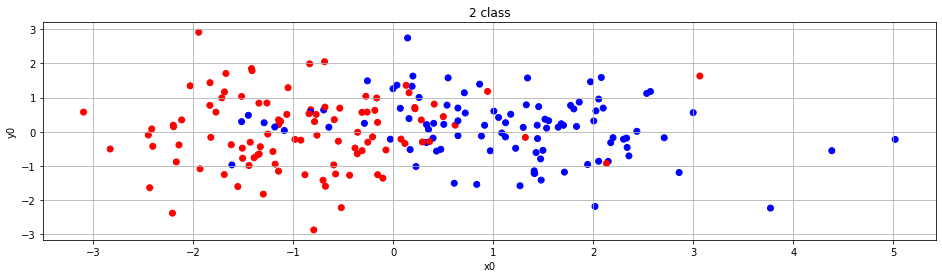

In [86]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(16,4))
plt.scatter(list(map(lambda x: x[0], classification_data_p)), list(map(lambda x: x[1], classification_data_p)), 
              c=classification_labels_p, cmap=colors)
plt.xlabel('x0')
plt.ylabel('y0')
plt.title('2 class')
plt.grid()
plt.show()

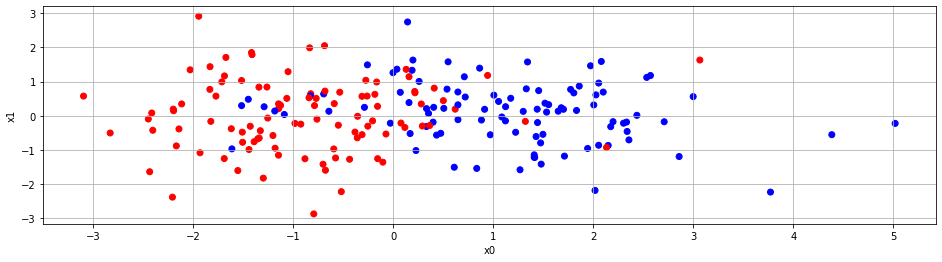

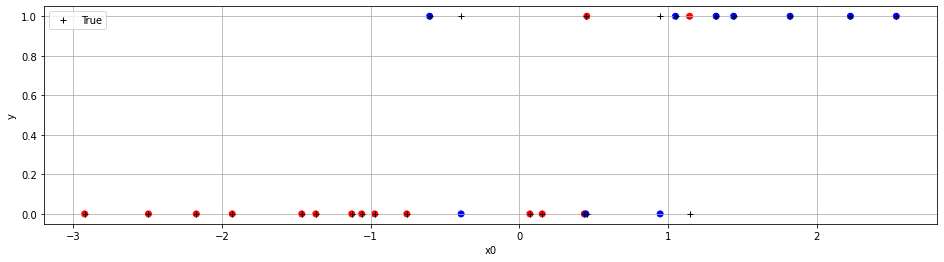

аккуратность модели :  0.8


In [90]:

n_samples = classification_data_p.shape[0]
plt.figure(figsize=(16,4))

ind_ = np.arange(0,classification_data_p.shape[0])


plt.scatter(list(map(lambda x: x[0], classification_data_p[ind_,:])), list(map(lambda x: x[1], classification_data_p[ind_,:])),
                c=classification_labels_p[ind_], cmap=colors)


tree_ = DecisionTreeClassifier(max_depth=100).fit( classification_data_p[ind_,:],classification_labels_p[ind_])

plt.xlabel('x0') 
plt.ylabel('x1')   
plt.grid()     
plt.show()


N1 = 150
N2 = 175
plt.figure(figsize=(16,4))
y_p = tree_.predict_proba(classification_data_t)[N1:N2,1]
plt.scatter(classification_data_t[N1:N2,0], y_p,
                c=classification_labels_t[N1:N2], cmap=colors)
plt.plot(classification_data_t[N1:N2,0], classification_labels_t[N1:N2], '+k',
               label = 'True')
plt.grid()
plt.xlabel('х0') 
plt.ylabel('y')    
plt.legend()
plt.show()

print('аккуратность модели : ',accuracy_score(classification_labels_t[N1:N2],(y_p>0.5).astype(int)))

Проверим для разной глубины деревьев


В случае задачи регрессии при использовании композиции $a(x)$ из $N$ _базовых алгоритмов_ $b_{n}(x)$ ответом будет считаться среднее значение ответа каждого алгоритма

$$a(x) = \frac{1}{N}\sum_{n=1}^{N}b_{n}(x),$$

в задачах классификации, соответственно, знак полученного усредненного ответа или (что аналогично) класс определяется путем _голосования_: объект относится к классу, за который "проголосовало" наибольшее число базовых алгоритмов.


Вот так примерно выглядит решение для линейных моделей:

In [91]:
from sklearn.linear_model import LogisticRegression

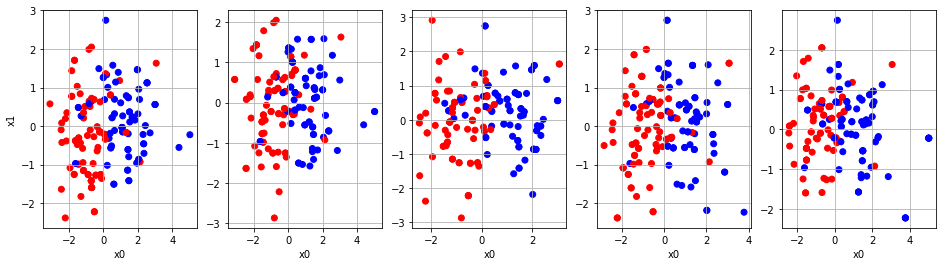

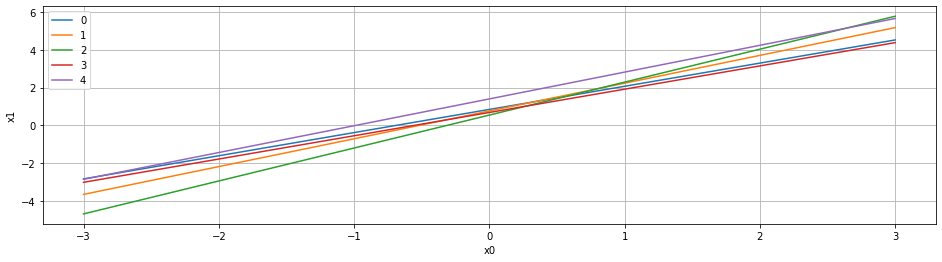

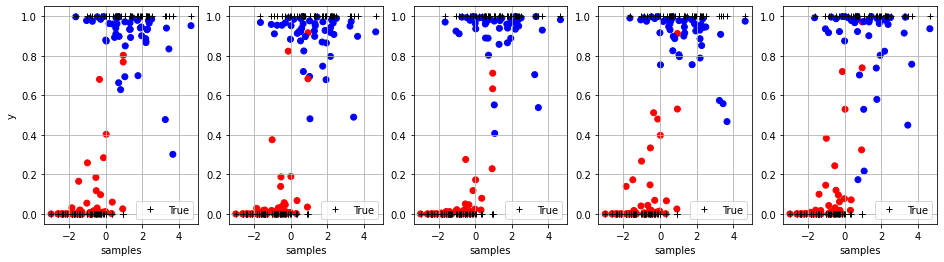

In [95]:
N_set = 5 
partition_set = 0.8
n_samples = int(np.ceil(classification_data_p.shape[0]*partition_set))+1
plt.figure(figsize=(16,4))
Linear_model = []
for i in range(N_set):
    plt.subplot(1,N_set,i+1)
    ind_ = np.random.randint(0,classification_data_p.shape[0],n_samples ) # собрали случайную подвыборку примеров для очередной модели
    
    plt.scatter(list(map(lambda x: x[0], classification_data_p[ind_,:])), 
                list(map(lambda x: x[1], classification_data_p[ind_,:])),
                c=classification_labels_p[ind_], cmap=colors)
    
    log_reg = LogisticRegression().fit( classification_data_p[ind_,:],
                                       classification_labels_p[ind_])  #  строим модель не по всем данным для тренировки, а только по части
    Linear_model.append(log_reg)  # сохраняем новую модель
    plt.grid(True) 
    plt.xlabel('x0')
    if i == 0:
      plt.ylabel('x1')
plt.show()

# отобразим все модели как есть 
plt.figure(figsize=(16,4))
plt.grid(True)
x = np.array([-3,3])
for i in range(N_set):

    coef = Linear_model[i].coef_
    intercept =  Linear_model[i].intercept_
    y = x * coef[0][0]+intercept[0]
    # новая модель
    plt.plot(x,y, label = str(i))
plt.xlabel('x0')
plt.ylabel('x1')        
plt.legend()
plt.show()

# интервал индексов для предсказания (просто быстрее работает на коротком наборе)
N1 = 50
N2 = 150
# предсказание по моделям 
plt.figure(figsize=(16,4))
for i in range(N_set):
    plt.subplot(1,N_set,i+1)
    # предсказание на тестовых данных
    y_p = Linear_model[i].predict_proba(classification_data_t)[N1:N2,1]
    
    plt.scatter(classification_data_t[N1:N2,0], y_p,
                c=classification_labels_t[N1:N2], cmap=colors)
    plt.plot(classification_data_t[N1:N2,0], classification_labels_t[N1:N2], '+k',
               label = 'True')
    plt.grid() 
    plt.xlabel('samples')
    if i == 0:
      plt.ylabel('y')    
    plt.legend()
plt.show()
    
    

Все ошибались, но все ошиблись на разном:

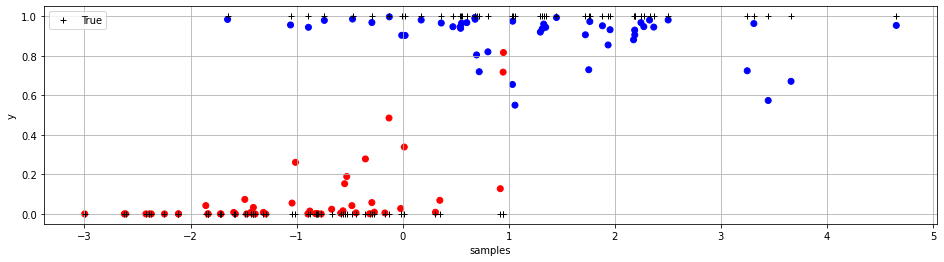

In [96]:
N1 = 50
N2 = 150
plt.figure(figsize=(16,4))
y_p = np.zeros(N2-N1)
for i in range(N_set):
    y_p += Linear_model[i].predict_proba(classification_data_t)[N1:N2,1]

y_p = y_p/N_set #  Это новое решение ансамбля    
plt.scatter(classification_data_t[N1:N2,0], y_p,
                c=classification_labels_t[N1:N2], cmap=colors)
plt.plot(classification_data_t[N1:N2,0], classification_labels_t[N1:N2], '+k',
               label = 'True')
plt.grid() 
plt.xlabel('samples')
plt.ylabel('y')      
plt.legend()
plt.show()

# **Случайный лес**

Одни из самых хорошо зарекомендовавших себя на практике решения задач классификации и регрессии с использованием деревьев решения - это _случайные леса_ и _градиентный бустинг_. В этом уроке пойдет речь о первом методе.

Случайные леса названы так из-за того, что в процесс построения деревьев, из которых они состоят, внесен элемент случайности для обеспечения уникальности каждого из деревьев. Такая рандомизация заключается в обучении базовых алгоритмов на разных подвыборках обучающей выборки. Один из способов построения случайных подвыборок - _бутстрап (bootstrap)_. Этот метод заключается в получении из выборки длины $l$ нескольких разных выборок той же длины $l$. Для получения бутстрап-выборки из исходной выборки $l$ раз выбирается случайный элемент, причем каждый раз новый элемент выбирается из всей выборки. Таким образом, в полученной в конечном итоге бутстрап-выборке некоторые элементы исходной выборки будут встречаться несколько раз, а некоторые (примерно 37% выборки) будут вовсе отсутствовать, и при повторении $N$ раз мы получим $N$ разных выборок длиной $l$. Например, если у нас есть исходная выборка вида [a, b, c, d, e], возможными бутстрап-выборками могут быть [a, b, a, c, b] или [b, e, e, d, b] и т.д.

Объединение нескольких деревьев с одинаковым смещением в композицию не будет приводить к увеличению ее смещения, а вот компонента разброса будет снижаться, если базовые алгоритмы независимы, то есть не коррелируют друг с другом: разброс композиции при усреднении ответов будет в $N$ раз меньше разброса одного базового алгоритма. Однако, на практике базовые алгоритмы всегда в той или иной степени скоррелированы, так как обучаются на подвыборках одной выборки, поэтому возникает необходимость уменьшения корреляции получаемых алгоритмов.

Есть два подхода, позволяющих уменьшить корреляцию: _бэггинг_ (обучение базовых алгоритмов на случайной подвыборке) и _метод случайных подпространств_ (обучение базовых алгоритмов на случайном подмножестве признаков) или их комбинация. В этом случае возникают гиперпараметры (параметры, которые нельзя найти или оценить по обучающей выборки, обучив алгоритм единожды) - размер подвыборки или подмножества признаков. Чем меньше брать обучающую подвыборку при бэггинге, тем меньше будет корреляция между алгоритмами, но тем больше вероятность переобучения деревьев, составляющих ансамбль.

Случайная подвыборка:

In [97]:
y_p.shape

(100,)

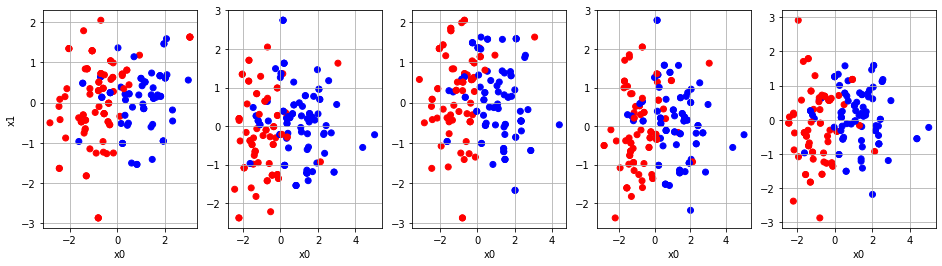

аккуратность модели  0 :  0.89
аккуратность модели  1 :  0.83
аккуратность модели  2 :  0.91
аккуратность модели  3 :  0.79
аккуратность модели  4 :  0.86


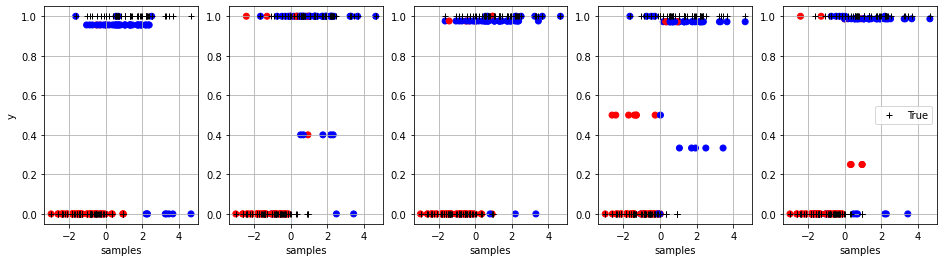

аккуратность ансамбля :  0.91


In [182]:
N_set = 5 
partition_set = 0.8
n_samples = int(np.ceil(classification_data_p.shape[0]*partition_set))+1
plt.figure(figsize=(16,4))
tree_model = []

for i in range(N_set):
    plt.subplot(1,N_set,i+1)
    ind_ = np.random.randint(0,classification_data_p.shape[0],n_samples )
    plt.scatter(list(map(lambda x: x[0], classification_data_p[ind_,:])), list(map(lambda x: x[1], classification_data_p[ind_,:])),
                c=classification_labels_p[ind_], cmap=colors)
    tree_ = DecisionTreeClassifier(max_depth=3).fit( classification_data_p[ind_,:],classification_labels_p[ind_])
    tree_model.append(tree_)
    plt.grid() 
    plt.xlabel('x0')
    if i == 0:
      plt.ylabel('x1') 
    
plt.show()


N1 = 50
N2 = 150
y_pa = np.zeros((N2-N1,))
plt.figure(figsize=(16,4))
for i in range(N_set):
    plt.subplot(1,N_set,i+1)
    y_p = tree_model[i].predict_proba(classification_data_t)[N1:N2,1]
    y_pa += y_p
    plt.scatter(classification_data_t[N1:N2,0], y_p,
                c=classification_labels_t[N1:N2], cmap=colors)
    plt.plot(classification_data_t[N1:N2,0], classification_labels_t[N1:N2], '+k',
               label = 'True')
    plt.grid() 
    plt.xlabel('samples')
    if i == 0:
      plt.ylabel('y') 
    print('аккуратность модели ',i,': ',accuracy_score(classification_labels_t[N1:N2],(y_p>0.45).astype('int')))
plt.legend()
plt.show()
y_pa = y_pa/N_set
print('аккуратность ансамбля : ',accuracy_score(classification_labels_t[N1:N2],(y_pa>0.45).astype('int') ))

Случайное подпространство:

число признаков :  9
аккуратность модели  0 :  0.83


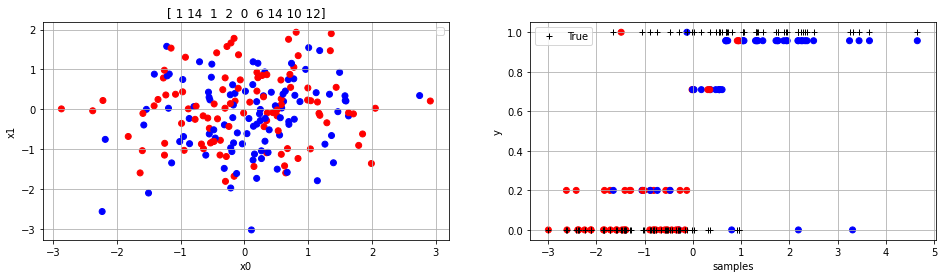

аккуратность модели  1 :  0.83


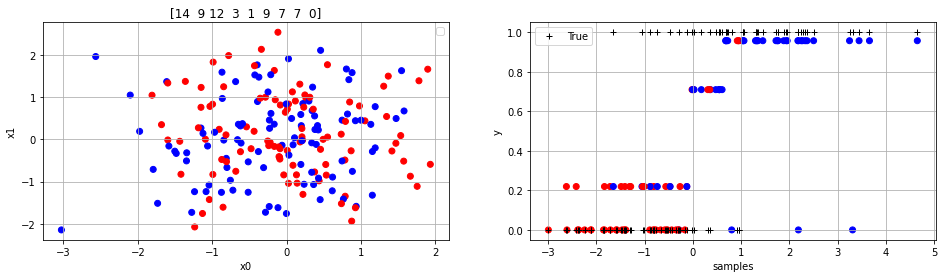

аккуратность модели  2 :  0.85


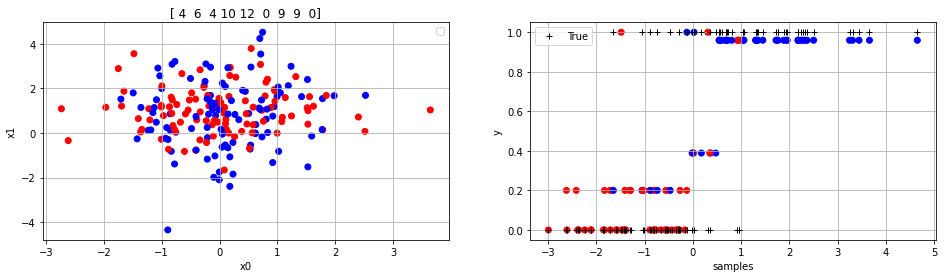

аккуратность модели  3 :  0.56


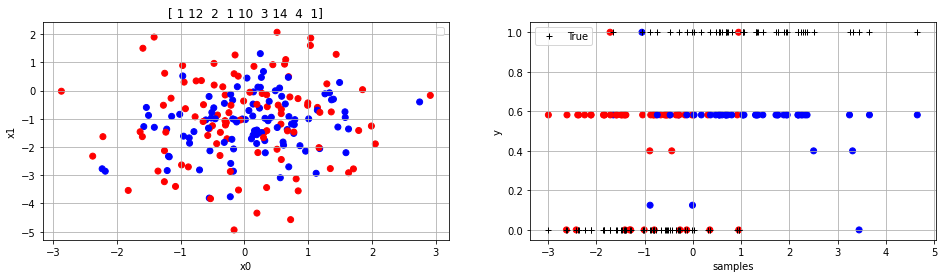

аккуратность модели  4 :  0.48


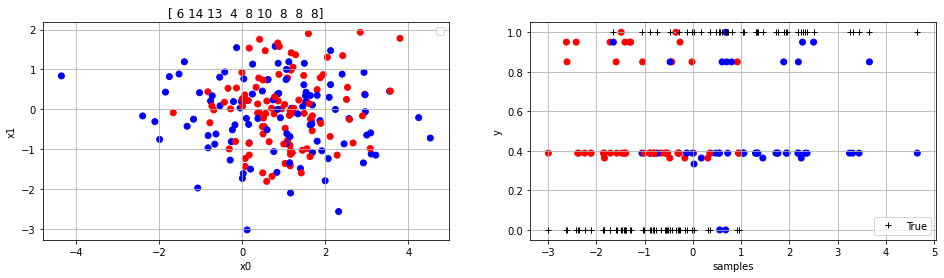

аккуратность ансамбля :  0.82


In [183]:
N_set = 5 
partition_feat = 0.5
n_feature = int(np.ceil(classification_data_p.shape[1]*partition_feat))+1
print('число признаков : ',n_feature)

tree_model = []
y_pa = np.zeros(N2-N1)
for i in range(N_set):
    plt.figure(figsize=(16,4))
    plt.subplot(1,2,1)
    ind_ = np.random.randint(0,classification_data_p.shape[1], n_feature )
    plt.scatter(list(map(lambda x: x[0], classification_data_p[:,ind_])), list(map(lambda x: x[1], classification_data_p[:,ind_])),
                c=classification_labels_p, cmap=colors)
    tree_ = DecisionTreeClassifier(max_depth=3).fit( classification_data_p[:,ind_],classification_labels_p)
    tree_model.append(tree_)
    plt.title(str(ind_))
    y_p += tree_model[i].predict_proba(classification_data_t[:,ind_])[N1:N2,1]
    plt.grid()
    plt.legend()
    plt.xlabel('x0')
    plt.ylabel('x1') 
    
       



    plt.subplot(1,2,2)
    y_p = tree_model[i].predict_proba(classification_data_t[:,ind_])[N1:N2,1]
    y_pa += y_p
    plt.scatter(classification_data_t[N1:N2,0], y_p,
                c=classification_labels_t[N1:N2], cmap=colors)
    plt.plot(classification_data_t[N1:N2,0], classification_labels_t[N1:N2], '+k',
               label = 'True')
    plt.grid() 
    plt.xlabel('samples')
    plt.ylabel('y') 
    print('аккуратность модели ',i,': ',accur(classification_labels_t[N1:N2],y_p))
    plt.legend()
    
    plt.show()
print('аккуратность ансамбля',': ',accur(classification_labels_t[N1:N2],y_pa/N_set))

## Алгоритм построения случайного леса

При построении случайного леса вначале генерируется количество бутстрап-выборок, равное количеству деревьев в алгоритме. Для уменьшения корреляции базовых алгоритмов рандомизируют сам процесс построения каждого дерева: если в стандартном методе построения деревьев мы в каждом узле выбираем $j$-й признак и порог $t$, с которым сравнивается его значение, и потом эти значения оптимизируются с помощью функции ошибки, то в методе случайного леса в каждой вершине $j$-й признак выбирается не из всего пространства признаков, а из его случайного подмножества размера $m$, __которое каждый раз выбирается заново__ (в этом отличие от метода случайных подпространств, где подпространство выбирается единожды и используется для построения всего дерева). 

Есть некоторые практически рекомендации по построению случайных лесов: в задачах классификации рекомендуется брать $m = \sqrt{d}$, где $d$ - общее число признаков, и строить дерево до тех пор, пока в каждом листе не останется по одному объекту, а в задаче регрессии принимать $m = d/3$ и строить дерево, пока в листьях не останется по пять объектов.

Далее построенные деревья объединяются в композицию, и при предсказаниях с его помощью используется усредненный ответ на каждом дереве.

### Out-of-Bag

Вспомним, что каждое дерево $b_{n}$, составляющее случайный лес, строится на основе бутстрапированной выборки $X_{n}$. При этом примерно 37% объектов не попадают в эту выборку, и дерево на них не обучается. Эти объекты можно использовать для оценки качества полученного алгоритма, это и называется _out-of-bag error_. Для каждог объекта $x_{i}$ мы можем найти деревья, которые на нем не обучались, и вычислить ошибку: она рассчитывается как сумма значений ошибки для среднего ответа на каждом объекте $x_{i}$ среди деревьев, которые на нем не обучались:

$$OOB = \sum^{l}_{i=1}L\left ( y_{i}, \:\frac{1}{\sum^{N}_{n=1}[x_{i}\notin X_{n}]} \sum^{N}_{n=1}[x_{i} \notin X_{n}]b_{n}(x_{i}) \right ).$$

Здесь $L(y, z)$ - функция потерь, а выражение в скобках и представляет из себя среднюю ошибку на объекте $x_{i}$ среди деревьев, которые на нем не обучались.

При использовании этого метода оценивания качества исчезает необходимость использовать отложенные выборки и кросс-валидацию при обучении случайных лесов.

## Реализация случайного леса

Для лучшего понимания алгоритма построения случайного леса реализуем его на Python.

In [184]:
# сгенерируем данные, представляющие собой 500 объектов с 5-ю признаками
classification_data, classification_labels = datasets.make_classification(n_samples=500,
                                                      n_features = 5, n_informative = 5, 
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=23)

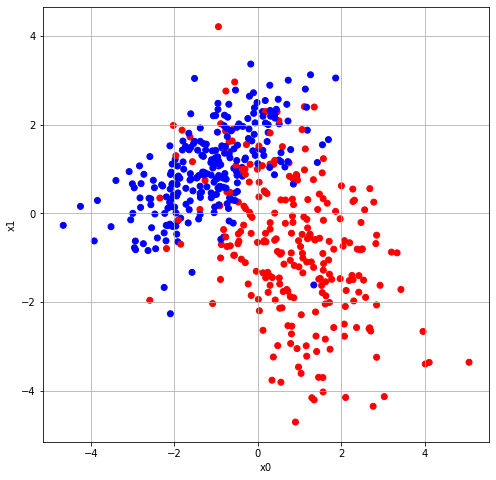

In [185]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)
plt.grid()
plt.xlabel('x0')
plt.ylabel('x1') 
plt.show()

Реализуем генерацию $N$ бутстрап-выборок и подмножества признаков для нахождения разбиения в узле.

In [186]:
random.seed(42)

def get_bootstrap(data, labels, N):
    n_samples = data.shape[0]
    bootstrap = []
    
    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]
        bootstrap.append((b_data, b_labels))
        
    return bootstrap

In [187]:
def get_subsample(len_sample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = [i for i in range(len_sample)]
    
    len_subsample = int(np.sqrt(len_sample))
    subsample = []
    
    random.shuffle(sample_indexes)
    for _ in range(len_subsample):
        subsample.append(sample_indexes.pop())
        
    return subsample

Теперь добавим функцию формирования случайного леса.

In [188]:
def random_forest(data, labels, n_trees, max_depth  = 3):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(DecisionTreeClassifier(max_depth=max_depth).fit(b_data, b_labels))
        
    return forest

In [189]:
# предсказание голосованием деревьев

def tree_vote(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(tree.predict(data ))
    
    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
    
    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return voted_predictions

Далее мы сделаем обычное разбиение выборки на обучающую и тестовую, как это делалось ранее. Оценить ошибку этого же алгоритма по методу Out-of-Bag будет вашим домашним заданием к этому уроку.

In [190]:
# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [191]:
# Введем функцию подсчета точности как доли правильных ответов

def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

Теперь построим несколько случайных лесов с разным количеством деревьев в них.

Построим лес из одного дерева

In [196]:
acc = []
numb_tree = [1,3,10,50, 100]
my_forests = []
for n_trees in numb_tree:
  my_forest = random_forest(train_data, train_labels, n_trees, max_depth = 6)
  my_forests += [my_forest]
  # Получим ответы для обучающей выборки 
  train_answers = tree_vote(my_forest, train_data)
  # И получим ответы для тестовой выборки
  test_answers = tree_vote(my_forest, test_data)
  # Точность на обучающей выборке
  train_accuracy = accuracy_score(train_labels, train_answers)
  print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')
  # Точность на тестовой выборке
  test_accuracy = accuracy_score(test_labels, test_answers)
  print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

  acc += [[train_accuracy,test_accuracy]]

Точность случайного леса из 1 деревьев на обучающей выборке: 0.943
Точность случайного леса из 1 деревьев на тестовой выборке: 0.893
Точность случайного леса из 3 деревьев на обучающей выборке: 0.954
Точность случайного леса из 3 деревьев на тестовой выборке: 0.927
Точность случайного леса из 10 деревьев на обучающей выборке: 0.983
Точность случайного леса из 10 деревьев на тестовой выборке: 0.980
Точность случайного леса из 50 деревьев на обучающей выборке: 0.994
Точность случайного леса из 50 деревьев на тестовой выборке: 0.967
Точность случайного леса из 100 деревьев на обучающей выборке: 0.994
Точность случайного леса из 100 деревьев на тестовой выборке: 0.980


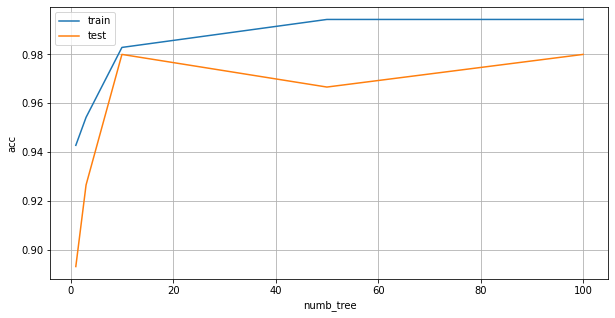

In [197]:

acc = np.array(acc)
plt.figure(figsize = (10,5))
plt.plot(numb_tree,acc[:,0], label = 'train')
plt.plot(numb_tree,acc[:,1], label = 'test') 
plt.legend()
plt.xlabel('numb_tree')
plt.ylabel('acc')
plt.grid()
plt.show() 

(55161, 3) (55161, 1) (55161, 1)


Text(0.5, 1.0, 'Test accuracy=0.98')

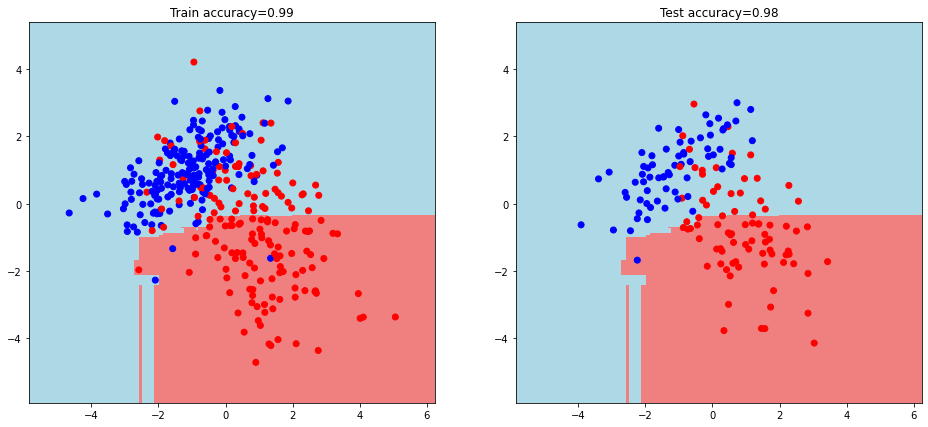

In [198]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    xx,yy = np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step)) 
    x = xx.reshape(-1,1)
    y = yy.reshape(-1,1)
    f = np.ones((x.shape[0],data[:, 2:].shape[1]))
    print(f.shape,x.shape,y.shape)
    data_gr = np.concatenate((x,y,f),axis=1)
    return xx,yy , data_gr# список массивов координатных сеток

tree_i = -1
plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy,gr = get_meshgrid(train_data)
mesh_predictions = np.array(tree_vote( my_forests[tree_i],gr)).reshape(xx.shape) # определяем цвета квадратов в сетке
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')

Как можно увидеть из показателей качества предсказаний, точность случайного леса возрастает при увеличении числа деревьев в нем. При этом по точности на тестовой выборке можно сказать, что при увеличении количества деревьев до 50 наш лес не переобучается. Это одна из основных особенностей случайного леса - он не переобучается при увеличении числа базовых алгоритмов, а ошибка выходит на асимптоту.

Случайный лес : sklearn.ensemble.RandomForestClassifier -  https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

## AdaBoost

Алгоритм AdaBoost (Adaptive boosting) также в настоящее время является одним из подвидов градиентного бустинга, однако фактически он является своего рода "предшественником" алгоритма градиентного бустинга, после разработки которого став его частным случаем.

Для задачи бинарной классификации он заключается в использовании слабых классификаторов (например, деревьев глубиной 1 - так называемых "пней") в цикле, с придаванием объектам весов. После каждого шага итерации, когда разделяющая плоскость классификатора делит пространство объектов на две части, веса объектов перераспределяются, и веса неправильно классифицированных объектов увеличиваются, чтобы на следующей итерации классификатор акцентировался на этих объектах. Классификатору также присваивается вес в зависимости от его точности. Затем полученные деревья с весами объединяются в один сильный классификатор. В этом и заключается адаптивность алгоритма. Алгоритм AdaBoost также называют алгоритмом усиления классификаторов.

Таким образом, его алгоритм заключается в следующем:

__1.__ Инициализация начальных весов объектов из выборки длиной $l$:

$$D_{1}(i) = \frac{1}{l}$$

__2.__ Для каждого из $N$ деревьев в ансамбле:

- находим классификатор $b_{n}$, который минимизирует взвешенную ошибку классификации

$$b_{n} = \underset{b}{\text{argmin}}\;\varepsilon_{j},$$

    где 

$$\varepsilon_{j} = \sum_{i=1}^{l}D_{n}(i)[y_{i}\neq b_{j}(x)]$$

- критерием остановки является значение $\varepsilon_{j} \geq 0.5$. При таком значении ошибки нужно выбрать другой классификатор и продолжить.

- выбираем вес для дерева $\alpha_{n}$ по формуле

$$\alpha_{n} = \frac{1}{2}\text{ln}\frac{1 - \varepsilon_{n}}{\varepsilon_{n}}$$

- обновляем веса при объектах:

$$D_{n+1}(i) = \frac{D_{n}(i)e^{-\alpha_{n}y_{i}b_{n}(x_{i})}}{Z_{n}},$$

выражение $y_{i}b_{n}(x_{i})$ в случае $Y = \{-1, 1\}$ будет равняться 1 для правильно классифицированных объектов и -1 для неправильно классифицированных, то есть по сути правильность классификации будет означать, будет $e^{\alpha_{n}}$ стоять в числителе или в знаменателе формулы. В случае $Y = \{0,1\}$ вес будет уменьшаться у неправильно классифицированных объектов, а у неправильно классифицированных - оставаться неизменным (до нормализации). $Z_{n}$ здесь - нормализующий параметр, выбираемый так, чтобы $D_{n+1}$ по своей сути являлся распределением вероятностей, то есть

$$\sum_{i=1}^{l}D_{n+1} = 1.$$

__3.__ Строим получившуюся модель

$$a(x) = \text{sign}\left( \sum_{n=1}^{N}\alpha_{n}b_{n}(x) \right).$$

Напишем его простую реализацию.

In [199]:

from sklearn.datasets import load_breast_cancer

In [200]:
X, y = load_breast_cancer(return_X_y=True)

Разделим выборку на обучающую и тестовую

In [201]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

Реализуем функцию подсчета ошибки

In [202]:
def get_error(pred, y):
    return sum(pred != y) / len(y)

И сам алгоритм

In [203]:
def adaboost(X, y, N):

    # Размер выборки
    n_objects = len(X)

    # Запишем количество классов в переменную
    n_classes = len(np.unique((y)))

    # Начальные веса деревьев
    w = np.ones(n_objects) / n_objects

    # Деревья с весами будем записывать в список
    models = []

    for n in range(N):
        # Зададим дерево и обучим его
        clf = DecisionTreeClassifier(max_depth=1)
        clf.fit(X, y, sample_weight=w)

        predictions = clf.predict(X)
        e = get_error(predictions, y)
        # отбросим дерево, если его ошибка больше 0.5
        # Запишем условие в общем виде (применимо к небинарным классификаторам)
        if e >= 1 - 1/n_classes: 
            break

        # Вычислим вес для дерева
        alpha = 0.5 * np.log((1 - e) / e)

        # Найдем индексы правильно классифицированных элементов
        match = predictions == y

        # Увеличим веса для неправильно классифицированных элементов
        w[~match] *= np.exp(alpha)

        # Нормализуем веса
        w /= w.sum()

        # Добавим дерево с весом в список
        models.append((alpha, clf))
    
    return models

Обучим алгоритм из 50 деревьев

In [204]:
N = 50

models = adaboost(X_train, y_train, N)

Теперь осуществим предсказание

In [205]:
def predict(X, models):
    
    n_classes = 2
    n_objects = len(X)
    
    # вначале обозначим предсказание нулевым массивом
    y_pred = np.zeros((n_objects, n_classes))
    
    for alpha, clf in models:
        prediction = clf.predict(X)
        # Для каждого предсказания будем прибавлять alpha к
        # элементу с индексом предсказанного класса
        y_pred[range(n_objects), prediction] += alpha
    
    # выберем индексы с максимальными суммарными весами -
    # получим предсказанные алгоритмом классы
    y_pred = np.argmax(y_pred, axis=1)
    
    return y_pred

print(f'Точность алгоритма на обучающей выборке: {(1 - get_error(predict(X_train, models), y_train)) * 100:.3f}')

Точность алгоритма на обучающей выборке: 98.357


In [206]:
print(f'Точность алгоритма на тестовой выборке: {(1 - get_error(predict(X_test, models), y_test)) * 100:.3f}')

Точность алгоритма на тестовой выборке: 91.608


Построим графики зависимости ошибки от количества базовых алгоритмов в ансамбле.

In [207]:
train_errors = []
test_errors = []

for n in range(1, 31):
    mods = adaboost(X_train, y_train, n)
    train_errors.append(get_error(predict(X_train, mods), y_train))
    test_errors.append(get_error(predict(X_test, mods), y_test))

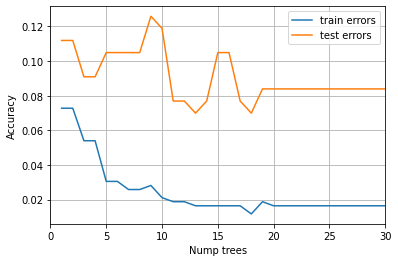

In [208]:
x = list(range(1, 31))

plt.xlim(0, 30)
plt.plot(x, train_errors, label='train errors')
plt.plot(x, test_errors, label='test errors')
plt.xlabel('Nump trees')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')
plt.grid()
plt.show()

Достоинствами алгоритма AdaBoost можно назвать простоту реализации, хорошую обобщающую способность и небольшую вычислительную сложность. В то же время, есть и недостатки - в первую очередь, склонность к переобучению при наличии в данных шума и выбросов: для наиболее трудноклассифицируемых объектов алгоритм будет определять очень большие веса и в итоге переобучаться на них. В то же время это является и плюсом: таким образом можно идентифицировать выбросы. 

## Алгоритм градиентного бустинга (GBM)

Итоговый алгоритм ищется в виде взвешенной суммы базовых алгоритмов (обратите внимание: не среднего, а суммы):

$$a_{N}(x) = \sum^{N}_{n=1}\gamma_{n}b_{n}(x).$$

В случае линейной регрессии задача состоит в минимизации среднеквадратичного функционала ошибки:

$$\frac{1}{l}\sum_{i=1}^{l}(a(x_{i}) - y_{i})^{2} \rightarrow \text{min}.$$

Так как ансамбль строится итеративно, нужно вначале обучить первый простой алгоритм:

$$b_{1}(x) = \underset{b}{\text{argmin}}\frac{1}{l}\sum_{i=1}^{l}(b(x_{i}) - y_{i})^{2}.$$

Как мы помним, такая задача легко решается методом градиентного спуска.

После того, как мы нашли первый алгоритм $b_{1}(x)$, нам нужно добавить в ансамбль еще один алгоритм $b_{2}(x)$. Для начала найдем разницу ответов первого алгоритма с реальными ответами:

$$s_{i}^{(1)} = y_{i} - b_{1}(x_{i}).$$

Если прибавить эти значения к полученным предсказаниям, получим идеальный ответ. Таким образом, новый алгоритм логично обучать так, чтобы его ответы были максимально близки к этой разнице, чтобы при их прибавлении к ответам первого алгоритма мы получили близкие к реальным. Значит, второй алгоритм будет обучаться на следующем функционале ошибки:

$$b_{2}(x) = \underset{b}{\text{argmin}}\frac{1}{l}\sum_{i=1}^{l}(b(x_{i}) - s_{i}^{(1)})^{2} = \underset{b}{\text{argmin}}\frac{1}{l}\sum_{i=1}^{l}(b(x_{i}) - (y_{i} - b_{1}(x_{i})))^{2}.$$

Каждый следующий алгоритм также настраивается на остатки композиции из предыдущих алгоритмов:

$$b_{N}(x) = \underset{b}{\text{argmin}}\frac{1}{l}\sum_{i=1}^{l}(b(x_{i}) - s_{i}^{(N)})^{2},$$ 

$$s_{i}^{(N)} = y_{i} - \sum_{n=1}^{N-1}b_{n}(x_{i}) = y_{i} - a_{N-1}(x_{i}).$$

Таким образом, каждый новый алгоритм корректирует ошибки предыдущих, и так продолжается до момента получения приемлемой ошибки на композиции. Вектор коэффициентов $s$ при этом называют _вектором сдвига_.

Выбор сдвига из условия $s_{i} = y_{i} - a_{N-1}(x_{i})$ требует точного совпадения полученных предсказаний и ответов, однако, в более общем случае вектор сдвига принимают с учетом особенностей используемой в данном случае функции потерь: вектор сдвига должен ее минимизировать, то есть направлять в сторону уменьшения. Как мы помним из метода градиентного спуска, направление наискорейшего убывания функции совпадает с ее антиградиентом. Таким образом, если при обучении мы минимизируем функционал ошибки $L(y,z)$

$$\sum_{i=1}^{l}L(y_{i}, a_{N-1}(x_{i}) + s_{i}) \rightarrow \underset{s}{\text{min}},$$

сдвиг на каждом шаге должен быть противоположен производной функции потерь в точке $z = a_{N-1}(x_{i})$. 

$$s_{i} = \left.-\frac{\partial L}{\partial z} \right|_{z = a_{N-1}(x_{i})}.$$

Каждый новый алгоритм таким образом выбирается так, чтобы как можно лучше приближать антиградиент ошибки на обучающей выборке. 

После того, как мы вычислили требуемый для минимизации ошибки сдвиг $s$, нужно настроить алгоритм $b_{N}(x)$ так, чтобы он давал максимально близкие к нему ответы, то есть обучать его именно на вектор сдвига. Близость ответов алгоритма к сдвигу обычно оценивается с помощью среднеквадратичной ошибки независимо от условий исхожной задачи (так как исходно используемая функция потерь $L$ уже учтена в сдвигах $s_{i}$):

$$b_{N}(x) = \underset{s}{\text{argmin}}\frac{1}{l}\sum_{i=1}^{l}(b(x_{i})-s_{i})^{2}.$$

Коэффициент $\gamma$ для найденного алгоритма также находится по аналогии с наискорейшим градиентным спуском:

$$\gamma_{N} = \underset{\gamma}{\text{argmin}}\sum_{i=1}^{l}L(y_{i},a_{N-1}(x_{i}) + \gamma b_{N}(x_{i})).$$

Обычно в качестве функции потерь в задачах регрессии принимается квадратичная функция потерь ($L_{2}$ loss):

$$L(y, z) = (y-z)^{2},$$

его производная по $z$ примет вид 

$$L'(y, z) = 2(z-y)$$

или модуль отклонения ($L_{1}$ loss)

$$L(y, z) = |y-z|,$$

его производная по $z$ будет иметь вид 

$$L'(y, z) = \text{sign}(z-y).$$

В случае классификации - логистическая функция потерь:

$$L(y, z) = log(1 + exp(-yz))$$

ее производная:

$$L'(y, z) = \frac{y_{i}}{1+exp(-yz)}.$$

Следует помнить, что компоненты $s_{i}$, вычисляемые через эти производные, берутся с минусом.

Аналогично алгоритму градиентного спуска, имеет смысл добавлять ответ каждого нового алгоритма не полностью, а с некоторым шагом $\eta \in (0, 1]$, так как базовые алгоритмы обычно достаточно простые (например, деревья малой глубины), и они могут плохо приближать вектор антиградиента, и тогда вместо приближения к минимуму мы будем получать случайное блуждание в пространстве. В градиентном бустинге такой прием называется сокращением шага.

$$a_{N}(x) = a_{N-1}(x) + \eta \gamma_{N} b_{N}(x).$$

Градиентный бустинг склонен к переобучению при увеличении числа итераций $N$ или глубины входящих в него деревьев. Стоит об этом помнить при построении алгоритма и выбирать оптимальные параметры по отложенной выборке или с помощью кросс-валидации.

В конечном итоге алгоритм построения модели градиентного бустинга заключается в следующих шагах:

__1.__ Для инициализации выбирается произвольный простой алгоритм $b_{0}(x)$, в его роли можно брать обычные константные алгоритмы: в случае задачи регрессии это может быть

$$b_{0}(x) = 0$$

или среднее значение по всем объектам обучающей выборки 

$$b_{0}(x) = \frac{1}{l}\sum_{i=1}^{l}y_{i};$$

в случае классификации - самый часто встречающийся в выборке класс

$$b_{0}(x) = \underset{y}{\text{argmax}}\sum_{i=1}^{l}[y_{i} = y].$$

__2.__ Для каждой итерации вычисляется вектор сдвига $s$:

$$s = \left ( \left.-\frac{\partial L}{\partial z} \right|_{z = a_{n-1}(x_{1})},...,\left.-\frac{\partial L}{\partial z} \right|_{z = a_{n-1}(x_{l})}\right );$$

находится алгоритм

$$b_{n}(x) = \underset{s}{\text{argmin}}\frac{1}{l}\sum_{i=1}^{l}(b(x_{i})-s_{i})^{2};$$

находится оптимальный коэффициент $\gamma$

$$\gamma_{n} = \underset{\gamma}{\text{argmin}}\sum_{i=1}^{l}L(y_{i},a_{n-1}(x_{i}) + \gamma b_{n}(x_{i})).$$

и добавляется в имеющийся ансамбль с умножением на шаг $\eta$, называемый _скоростью обучения_ (опционно)

$$a_{n}(x) = a_{n-1}(x) + \eta \gamma_{n} b_{n}(x).$$

__3.__ При достижении критериев остановки компонуется итоговая модель.

### Стохастический градиентный бустинг

Как и в случае с градиентым спуском, есть так называемый стохастический градиентный бустинг, являющийся упрощенной (в плане потребления ресурсов) версией алгоритма. Его суть заключается в обучении каждого нового базового алгоритма на новой итерации не на всей обучающей выборке, а на некоторой ее случайной подвыборке. Практика показывает, что такой алгоритм позволяет получить такую же ошибку или даже уменьшить ее при том же числе итераций, что и в случае использования обычного бустинга.

## Реализация алгоритма градиентного бустинга

Реализуем средствами Python алгоритм градиентного бустинга для деревьев решений.

Реализация деревьев решений была дважды продемонстрирована в предыдущих уроках, в этом не будем ее повторять и возьмем готовую реализацию дерева решений для регрессии из библиотеки `sklearn`.

Используем один из "игрушечных" датасетов из той же библиотеки.

In [209]:
from sklearn.datasets import load_diabetes

In [210]:
X, y = load_diabetes(return_X_y=True)

Разделим выборку на обучающую и тестовую в соотношении 75/25.

In [211]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

Напишем функцию, реализующую предсказание в градиентном бустинге.

In [212]:
def gb_predict(X, trees_list, coef_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании прибавляются с шагом eta
    return np.array([sum([eta* coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])

В качестве функционала ошибки будем использовать среднеквадратичную ошибку. Реализуем соответствующую функцию.

In [213]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

Используем $L_{2}$ loss $L(y, z) = (y-z)^{2},$ ее производная по $z$ примет вид $L'(y, z) = 2(z-y)$. Реализуем ее также в виде функции (коэффициент 2 можно отбросить).

In [214]:
def bias(y, z):
    return (y - z)

Реализуем функцию обучения градиентного бустинга.

In [215]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, bias(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

Теперь обучим несколько моделей с разными параметрами и исследуем их поведение.

In [217]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta):
    train_prediction = gb_predict(X_train, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тренировочной выборке: {mean_squared_error(y_train, train_prediction)}')

    test_prediction = gb_predict(X_test, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тестовой выборке: {mean_squared_error(y_test, test_prediction)}')

Построим графики зависимости ошибки на обучающей и тестовой выборках от числа итераций.

In [222]:
def get_error_plot(n_trees, train_err, test_err):
    plt.xlabel('Iteration number')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    plt.plot(list(range(n_trees)), train_err, label='train error')
    plt.plot(list(range(n_trees)), test_err, label='test error')
    plt.legend(loc='upper right')
    plt.grid()
    plt.show()

Ансамбль в разном числе деревьев:

Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 1 на тренировочной выборке: 1056.1548513777818
Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 1 на тестовой выборке: 4021.2728853097747


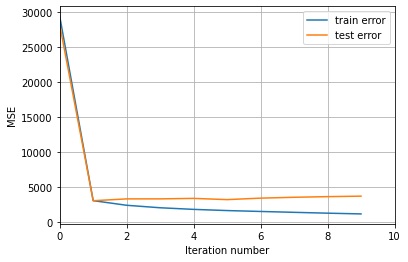

Ошибка алгоритма из 50 деревьев глубиной 3     с шагом 1 на тренировочной выборке: 62.08196902009847
Ошибка алгоритма из 50 деревьев глубиной 3     с шагом 1 на тестовой выборке: 4694.743384453778


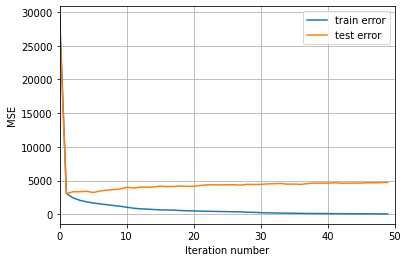

Ошибка алгоритма из 100 деревьев глубиной 3     с шагом 1 на тренировочной выборке: 1.017815767325971
Ошибка алгоритма из 100 деревьев глубиной 3     с шагом 1 на тестовой выборке: 4843.9957543373675


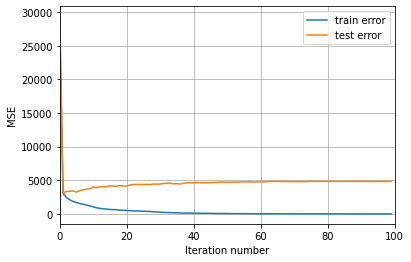

In [225]:
# Число деревьев в ансамбле
numb_trees = [10,50,100]
for n_trees in numb_trees:

  # для простоты примем коэффициенты равными 1
  coefs = [1] * n_trees

  # Максимальная глубина деревьев
  max_depth = 3

  # Шаг
  eta = 1

  trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

  evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

  get_error_plot(n_trees, train_errors, test_errors)

Варьируя параметры обучения градиентного бустинга можно добиваться различного уровня точности модели.

Существуют различные реализации градиентного бустинга, и одна из самых популярных и широко используемых - XGBoost (в Python содержится в библиотеке с аналогичным названием). С этой реализацией можно ознакомиться в дополнительных материалах.

## Дополнительные материалы

1. [Интерактивная демонстрация градиентного бустинга](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html)
2. [sklearn.datasets](https://scikit-learn.org/stable/datasets/index.html)
3. [sklearn.tree.DecisionTreeRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html)
4. [$L_{1}$ loss и $L_{2}$ loss](https://afteracademy.com/blog/what-are-l1-and-l2-loss-functions)
5. [XGBoost](https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture10-ensembles.pdf)
6. [AdaBoost](https://ru.wikipedia.org/wiki/AdaBoost)